# 2. Which DNA Patterns Play the Role of Molecular Clocks?



---



# Do We Have a “Clock” Gene?

The daily schedules of animals, plants, and even bacteria are controlled by an internal timekeeper called the **circadian clock**. However, the circadian clock can malfunction, resulting in a genetic disease known as **delayed sleep-phase syndrome** (DSPS).

The circadian clock must have some basis on the molecular level, which presents the question  - How do individual cells know when they should slow down or increase the production of certain proteins?

It has been found that many circadian genes, having names like *timeless*, *clock*, and *cycle*, orchestrate the behavior of hundreds of other genes and display a high degree of evolutionary conservation across species.

Maintaining the circadian clock in plants is a matter of life and death. Every plant cell keeps track of day and night independently of other
cells, and just three plant genes, called **LCY**, **CCA1**, and **TOC1**, are the **regulatory genes** responsible for this "timekeeping". They are controlled by external factors like nutrient availability or sunlight.

LCY, CCA1, and TOC1 are able to control the transcription of other genes because the regulatory proteins that they encode are **transcription factors** that turn other genes on and off. A transcription factor regulates a gene by binding to a specific short DNA interval called a **regulatory motif** in the gene's upstream region. For example, CCA1 binds to `AAAAAATCT` in the upstream region of many genes regulated by CCA1.

But how can we locate these regulatory motifs without knowing what they look like in advance? We need to develop algorithms for **motif finding**, the problem of discovering a “hidden message” shared by a collection of strings.

# Motif Finding Is More Difficult Than You Think

Motifs that are not very conserved and have many mutations are elusive. It would be possivle to solve this with the solution to the Frequent Words with Mismatches Problem for a concatenation of all the upstream regions. However, this would be slow when the $k$-mer size and the number of mismatches is large.

This is also not biologically accurate. A regulatory motif is a pattern that appears at least once (perhaps with variation) in each of many different regions that are scattered throughout the genome. It is not a pattern that clumps, or appears frequently, within a relatively short interval of the genome.

**A brute force algorithm for motif finding**

---

Given a collection of strings $\text{Dna}$ and an integer $d$, a $k$-mer is a **($k$, $d$)-motif** if it appears in every string from $\text{Dna}$ with at most $d$ mismatches. The **Implanted Motif Problem** is to find all ($k$, $d$)-motifs in $\text{Dna}$.

**Brute force search** (also known as **exhaustive search**) is a general problem-solving technique that explores all possible candidate solutions and checks whether each candidate solves the problem. Such algorithms require little effort to design and are guaranteed to produce a correct solution, but they may take an enormous amount of time, and the number of candidates may be too large to check.

A brute force approach for solving the Implanted Motif Problem is based on the observation that any ($k$, $d$)-motif must be at most $d$ mismatches apart from some $k$-mer appearing in one of the strings of $\text{Dna}$. Therefore, we can generate all such $k$-mers and then check which of them are ($k$, $d$)-motifs.

In [1]:
# Function to generate the 1-neighborhood of a k-mer

def immediate_neighbors(pattern):

  neighborhood = [pattern]

  for i in range(len(pattern)):

    prefix = pattern[:i]
    nucleotide = pattern[i]
    suffix = pattern[i+1:]

    alternates = list({"A","T","G","C"} - {nucleotide})

    for alternate in alternates:
      neighbor = prefix + alternate + suffix
      neighborhood.append(neighbor)

  return neighborhood

In [2]:
# Function to generate the d-neighborhood of a k-mer

def neighbors(pattern,d):

  neighborhood = [pattern]

  for i in range(d):
    current_neighborhood = neighborhood.copy()
    for neighbor in current_neighborhood:
      for immediate_neighbor in immediate_neighbors(neighbor):
        if immediate_neighbor not in neighborhood:
          neighborhood.append(immediate_neighbor)

  return neighborhood

In [3]:
# Function to find a motif in a collection of strings

def motif_enumeration(Dna,k,d):

  # Generating all k-mers in Dna

  k_mers = []
  string_k_mers = []
  for string in Dna:
    string_k_mer = []
    for i in range(len(string)):
      if string[i:i+k] not in k_mers and len(string[i:i+k]) == k:
        k_mers.append(string[i:i+k])
        string_k_mer.append(string[i:i+k])
    string_k_mers.append(string_k_mer)


  # Checking if any of the k-mers form motifs

  motifs = []

  for k_mer in k_mers:
    for pattern in neighbors(k_mer,d):
      neighborhood = neighbors(pattern,d)
      count = 0
      for string_k_mer in string_k_mers:
        for k_mer in string_k_mer:
          if k_mer in neighborhood:
            count += 1
            break
      if count == len(Dna):
        motifs.append(pattern)

  return list(set(motifs))

In [4]:
# To find all 15-mers that occur with at most 1 mismatch in each string of Dna
Dna = ["atgaccgggatactgatAAAAAAAAGGGGGGGggcgtacacattagataaacgtatgaagtacgttagactcggcgccgccg".upper(),"acccctattttttgagcagatttagtgacctggaaaaaaaatttgagtacaaaacttttccgaataAAAAAAAAGGGGGGGa".upper()]
motif_enumeration(Dna,15,1)

['GATAAAAAAAAAGGG',
 'TAAAAAAAAGGGGGG',
 'AAAAAAAAGGGGGGA',
 'AAAAAAAAAAGGGGG',
 'ATAAAAAAAGGGGGG',
 'TAAAAAAAATGGGGG',
 'AATAAAAAAAAGGGG',
 'AAAAAAAACGGGGGG',
 'CAAAAAAAAGGGGGG',
 'AAAAAAAAGGGGGGG',
 'ATAAAAAAAAAGGGG',
 'AAAAAAAGAGGGGGG',
 'AAAAAAGGGGGGGGA',
 'AAAAAAAGGGGGGGC',
 'TAAAAAAAAAGGGGG',
 'ATAAAAAAAATGGGG',
 'AAAAAAAGGGGGGGA',
 'AAAAAAAATGGGGGG',
 'AAAAAAAGGGGGGGT',
 'TAAAAAAAACGGGGG',
 'ATAAAAAAAAGGGGG',
 'AAAAAAAAAGGGGGG',
 'ATAAAAAAAACGGGG',
 'GAAAAAAAAGGGGGG',
 'AAAAAAAGGGGGGGG',
 'TTAAAAAAAAGGGGG']

`motif_enumeration` is unfortunately rather slow for large values of $k$ and $d$.

# Scoring Motifs

Although the Implanted Motif Problem offers a useful abstraction of the biological problem of motif finding, it has some limitations. Biologists do not expect that all circadian genes are regulated by the same transcription factor. For such noisy datasets, any algorithm for the Implanted Motif Problem would fail, because as long as a single sequence does not contain the transcription factor binding site, a ($k$, $d$)-motif would not even exist!

A more appropriate problem formulation would be to select a $k$-mer from each string and score these $k$-mers depending on how similar they are to each other.

To define scoring, consider $t$ DNA strings, each of length $n$, and select a $k$-mer from each string to form a collection $\text{Motifs}$, which we represent as a $t \times k$ **motif matrix**. We indicate the most frequent nucleotide in each column of the motif matrix by upper case letters. If there are multiple most popular nucleotides in a column, then we arbitrarily select one of them to break the tie.

By varying the choice of $k$-mers in each string, we can construct a large number of different motif matrices from a given sample of DNA strings. Our goal is to select $k$-mers resulting in the most “conserved” motif matrix, meaning the matrix with the most upper case letters (and thus the fewest number of lower case letters).

We define the score of a motif matrix as the number of unpopular (lower
case) letters in the motif matrix. Our goal is to find a collection of $k$-mers that minimizes this score.

We can construct the $4 \times k$ **count matrix**, counting the number of occurrences of each nucleotide in each column of the motif matrix. Dividing all the elements of the count matrix by $t$ results in the **profile matrix**, giving the frequencies of occurrences of each nucleotide in each column of the motif matrix. Finally, we form a **consensus string** from the most popular nucleotides in each column of the motif matrix (ties are broken arbitrarily).



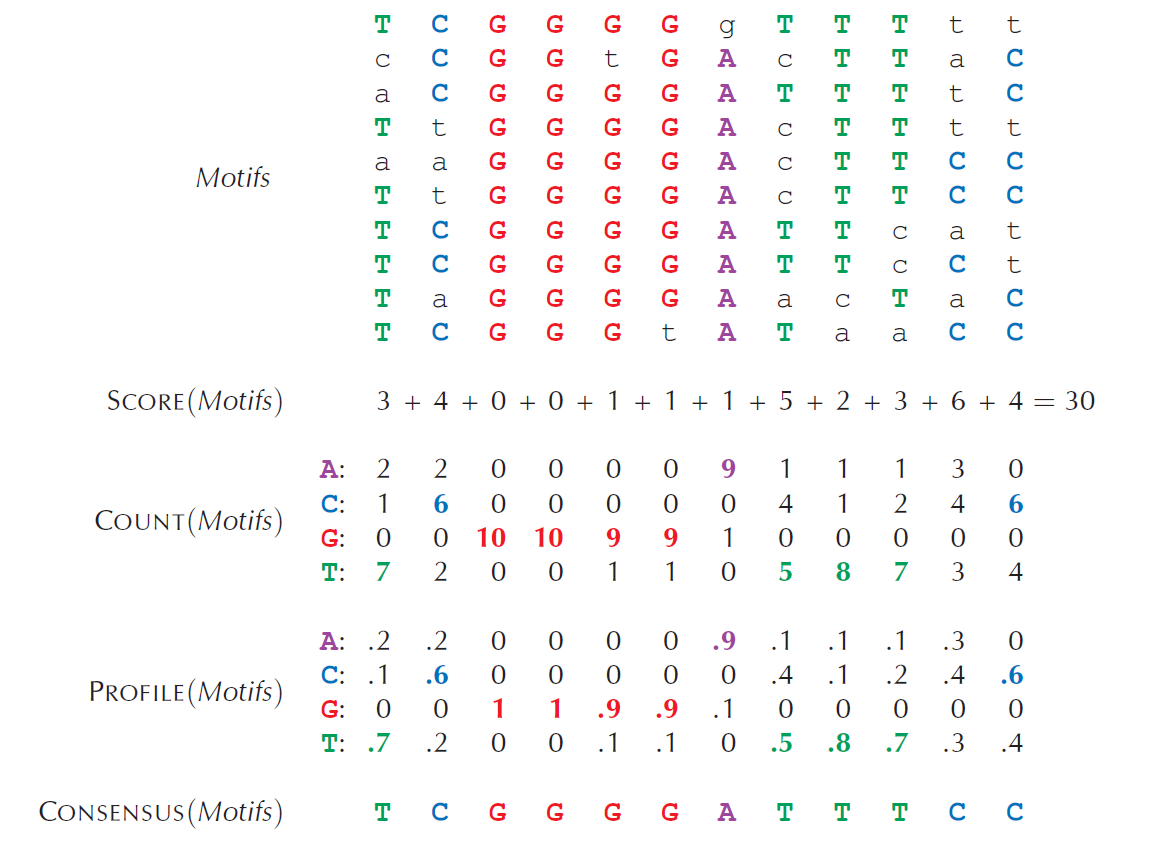

Consider the second column (containing 6 C, 2 A, and 2 T) and the final column (containing 6 C and 4 T) in the motif matrix above. Both of these columns contribute $4$ to the score. For many biological motifs, certain positions feature two nucleotides with roughly the same ability to bind to a transcription factor.

A more appropriate representation of the consensus string should include viable alternatives to the most popular nucleotides in each column. In this sense, the last column (6 C, 4 T) in the motif matrix above is “more conserved” than the second column (6 C, 2 A, 2 T), and should receive a lower score.

**Entropy and the motif logo**



---


Every column of the profile matrix corresponds to a probability distribution. **Entropy** is a measure of the uncertainty of a probability distribution, and is defined as

\begin{align}
        H(p_1,p_2,...,p_N) = -\sum_{i=1}^N p_i \cdot \log_{2} (p_i)
\end{align}

The more conserved the column, the smaller its entropy. Thus, entropy offers an improved method of scoring motif matrices: the entropy of a motif matrix is defined as the sum of the entropies of its columns.

The entropy of a completely conserved column is $0$. The entropy of a column with equally-likely nucleotides (all probabilities equal to $1/4$) has maximum possible entropy $-4 ⋅ (1/4) ⋅ \log_{2}(1/4) = 2$.

Another application of entropy is the **motif logo**, a diagram for visualizing motif conservation that consists of a stack of letters at each position. The relative sizes of letters indicate their frequency in the column. The total height of the letters in each column is based on the **information content** of the column, which is defined as $2 - H(p_1,p_2,...,p_N)$. The lower the entropy, the higher the information content,
meaning that tall columns in the motif logo are highly conserved.

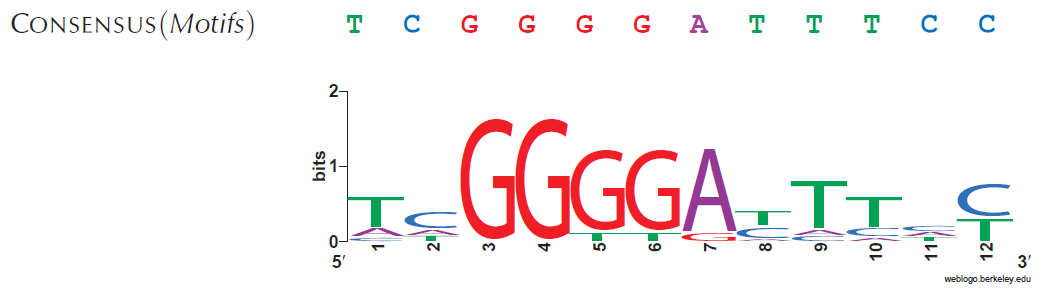

# From Motif Finding to Finding a Median String

After developing the scoring method for a collection of $k$-mers, we can formulate the **Motif Finding Problem**. Given a collection of strings, the problem asks us to find a set of $k$-mers, one from each string, that minimizes the score of the resulting motif.

A brute force algorithm for the Motif Finding Problem considers every possible choice of $k$-mers (one $k$-mer from each of the $t$ strings of $n$ nucleotides) and returns the collection of $k$-mers $\text{Motifs}$ having minimum score. There are $(n-k+1)^t$ ways to form $\text{Motifs}$. Finding the score requires $k⋅t$ steps. Assuming $n>k$, the running time of this algorithm is $\mathcal{O}(n^t⋅k⋅t)$. This is very slow for practical values of $n$ and $t$.

Instead of exploring all possible collections of $k$-mers, we can explore all possible $k$-mer consensus strings and find the best possible collection $\text{Motifs}$ for each consensus string.

To reformulate the Motif Finding Problem, we need to devise an alternative way of computing the score of $\text{Motifs}$. Instead of computing this column-wise as before, we can see that the same calculation can be performed row-wise to obtain the same score. For each row, the number of lowercase letters essentially represents the **Hamming distance** between the motif in the row and the consensus string. Thus, the score of the motif matrix is just a sum of Hamming distances.

\begin{align}
        \text{Score}(\text{Motifs}) = d(\text{Consensus},\text{Motifs}) = \sum_{i=1}^t \text{HammingDistance}(\text{Consensus},\text{Motifs}_i)
\end{align}

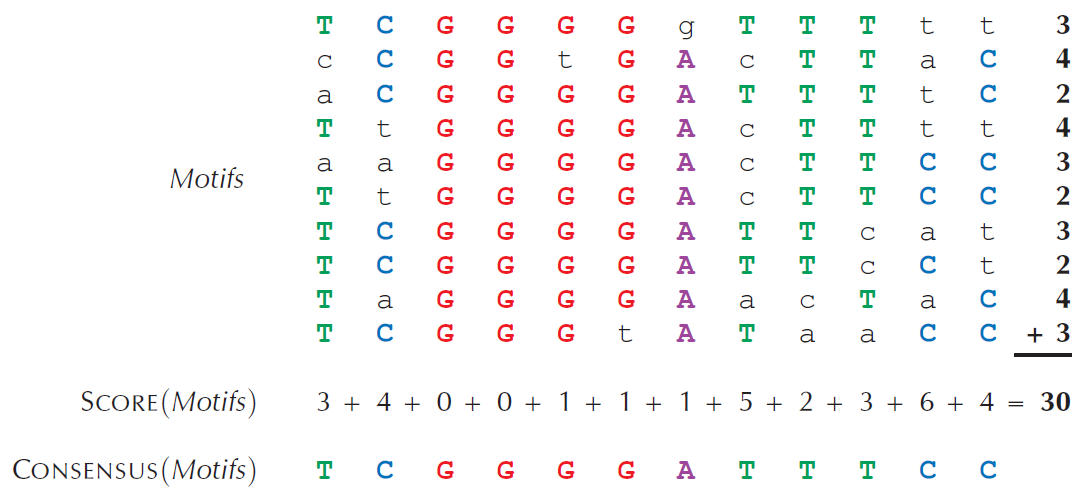

Thus, an equivalent formulation of the Motif Finding Problem would be to find a $k$-mer $\text{Pattern}$ that minimizes $d(\text{Pattern},\text{Motifs})$ among all $k$-mers $\text{Pattern}$ and all possible choices of $k$-mers $\text{Motifs}$ in $\text{Dna}$.

It appears as if we have made the task more difficult by having to search all $k$-mers $\text{Pattern}$ and all collections of $k$-mers $\text{Motifs}$. However, we don't have to explore all possible $\text{Motifs}$ in order to minimize $d(\text{Pattern},\text{Motifs})$.

We can observe that the $k$-mers in $\text{Motifs}$ can be generated independently. For each string in $\text{Dna}$, we select that $k$-mer with minimum Hamming distance from $\text{Pattern}$. The $k$-mer $\text{Pattern}$ that minimizes the sum of minimum Hamming distances (i.e., the score), is called the **median string**. Finding the median string is a double minimization problem. This can be solved exactly with a brute force algorithm.

In [5]:
def hamming_distance(string1,string2):

  length = min(len(string1),len(string2))

  distance = 0

  for i in range(length):
    if string1[i] != string2[i]:
      distance += 1

  return distance

In [6]:
def motifs_score(pattern,Dna):

  k = len(pattern)
  motifs = []
  current_score = 0

  for string in Dna:
    motif = ""
    min_dist = k
    for i in range(len(string)):
      if len(string[i:i+k]) == k and hamming_distance(pattern,string[i:i+k]) <= min_dist:
        motif = string[i:i+k]
        min_dist = hamming_distance(pattern,string[i:i+k])
    motifs.append(motif)
    current_score += min_dist

  return motifs, current_score

In [7]:
dna = ["ttaccttAAC".upper(),"gATAtctgtc".upper(),"ACGgcgttcg".upper(),"ccctAAAgag".upper(),"cgtcAGAggt".upper()]
motifs_score("AAA",dna)

(['AAC', 'ATA', 'ACG', 'AAA', 'AGA'], 5)

In [8]:
def median_string(Dna,k):

  current_score = k * len(Dna)
  median = ""

  k_mers = neighbors("A"*k,k)

  for pattern in k_mers:
    if motifs_score(pattern,Dna)[1] < current_score:
      current_score = motifs_score(pattern,Dna)[1]
      median = pattern

  return median, current_score

In [9]:
median_string(dna,3)

('CGT', 3)

This algorithm tests all $4^k$ $k$-mers $\text{Pattern}$. Each computation of the score requires $(n-k+1) \cdot k \cdot t ≈ n \cdot k \cdot t$ operations. Thus, `median_string` has a running time of $\mathcal{O}(4^k \cdot n \cdot k \cdot t)$, which is better than the $\mathcal{O}(n^t⋅k⋅t)$ of the brute force algorithm for the Motif Finding Problem for practical values of $n$, $k$ and $t$.

We have thus far assumed that the value of $k$ is known in advance, which is not the case in practice. As a result, we are forced to run our motif finding algorithms for different values of $k$ and then try to deduce the correct motif length. Since some regulatory motifs are rather long, `median_string` may be too slow to find them.

# Greedy Motif Search

Many algorithms are iterative procedures that must choose among many alternatives at each iteration. Some of these alternatives may lead to correct solutions, whereas others may not. **Greedy algorithms** select the “most attractive” alternative at each iteration. For example, a greedy algorithm in chess might attempt to capture an opponent's most valuable piece at every move. In general, most greedy algorithms typically fail to find an exact solution of the problem; instead, they are often fast **heuristics** that trade accuracy for speed in order to find an approximate solution.

In this section, we will explore a greedy approach to motif finding. We can view the columns of the profile matrix as probability distributions governing a four-sided biased die. The entire profile matrix represents $k$ such dice. We roll these dice to randomly generate a $k$-mer. A $k$-mer tends to have a higher probability of being generated when it is more similar to the consensus string of a profile.

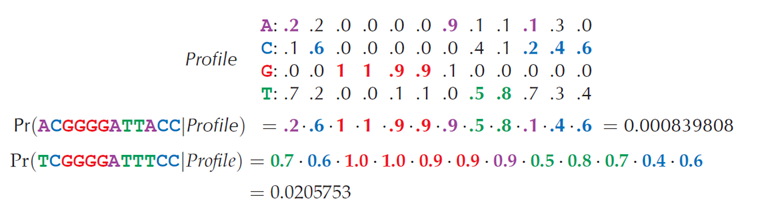

Given a profile matrix, we can evaluate the probability of every $k$-mer in a string and find a **profile-most probable** $k$-mer in that string, i.e., a $k$-mer that was most likely to have been generated by the profile matrix among all the $k$-mers in the string. In general, if there are multiple profile-most probable $k$-mers in the string, then we select the first such $k$-mer occurring in the string.



In [10]:
def profile_most_probable(profile,string,k):

  best_probability = 0
  best_k_mer = string[:k]

  for i in range(len(string)-k+1):
    k_mer = string[i:i+k]
    probability = 1
    for j in range(len(profile["A"])):
      nucleotide = k_mer[j]
      probability *= profile[nucleotide][j]
    if probability > best_probability:
      best_probability = probability
      best_k_mer = k_mer

  return best_probability,best_k_mer

In [11]:
profile = {"A":[0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.9, 0.1, 0.1, 0.1, 0.3, 0.0],
           "C":[0.1, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.1, 0.2, 0.4, 0.6],
           "G":[0.0, 0.0, 1.0, 1.0, 0.9, 0.9, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0],
           "T":[0.7, 0.2, 0.0, 0.0, 0.1, 0.1, 0.0, 0.5, 0.8, 0.7, 0.3, 0.4]}

string = "ggtACGGGGATTACCt".upper()

profile_most_probable(profile,string,12)

(0.0008398080000000002, 'ACGGGGATTACC')

Our proposed greedy motif search algorithm tries each of the $k$-mers in $\text{Dna}_1$ as the first motif. For a given choice of $\text{Motif}_1$ in $\text{Dna}_1$ , it then builds a profile matrix for this lone $k$-mer, and sets $\text{Motif}_2$ equal to the profile-most probable $k$-mer in $\text{Dna}_2$. It then iterates by updating the profile matrix to that formed from $\text{Motif}_1$ and $\text{Motif}_2$, and sets $\text{Motif}_3$ equal to the profile-most probable $k$-mer in $\text{Dna}_3$. After obtaining a $k$-mer from each string to create the collection $\text{Motifs}$, the algorithm checks to see if this collection outscores the current best scoring collection of motifs. The algorithm then shifts $\text{Motif}_1$ by 1 nucleotide in $\text{Dna}_1$ and starts the entire process again. In the end, we will obtain the best scoring collection $\text{Motifs}$.

In [12]:
def generate_profile(motifs):

  profile = {"A":[],"C":[],"G":[],"T":[]}
  t = len(motifs)
  k = min([len(string) for string in motifs])

  for i in range(k):
    nucleotides = []
    for string in motifs:
      nucleotides.append(string[i])
    for base in profile.keys():
      profile[base].append(nucleotides.count(base) / t)

  return profile

In [13]:
motifs = ['AAC', 'ATA', 'ACG', 'AAA', 'AGA']

generate_profile(motifs)

{'A': [1.0, 0.4, 0.6],
 'C': [0.0, 0.2, 0.2],
 'G': [0.0, 0.2, 0.2],
 'T': [0.0, 0.2, 0.0]}

In [14]:
import random

In [15]:
def generate_consensus(profile):

  consensus = ""

  bases = list(profile.keys())
  k = len(list(profile.values())[0])

  probabilities = []
  for i in range(k):
    probability = []
    for value in profile.values():
      probability.append(value[i])
    probabilities.append(probability)

  for probability in probabilities:
    max_value = max(probability)
    indices = []
    for i in range(len(probability)):
      value = probability[i]
      if value == max_value:
        indices.append(i)
    index = random.choice(indices)

    base = bases[index]
    consensus = consensus + base

  return consensus

In [16]:
generate_consensus(generate_profile(motifs))

'AAA'

In [17]:
def find_score(motifs):

  profile = generate_profile(motifs)
  consensus = generate_consensus(profile)

  current_score = 0

  for motif in motifs:
    current_score += hamming_distance(motif,consensus)

  return current_score

In [18]:
find_score(motifs)

5

In [19]:
def greedy_motif_search(Dna,k):

  t = len(Dna)
  best_motifs = [string[:k] for string in Dna]
  best_score = find_score(best_motifs)

  for i in range(len(Dna[0])-k+1):
    motif_1 = Dna[0][i:i+k]
    motifs = [motif_1]

    for j in range(1,t):
      profile = generate_profile(motifs)
      motifs.append(profile_most_probable(profile,Dna[j],k)[1])

    score = find_score(motifs)
    if score < best_score:
      best_motifs = motifs
      best_score = score

  return best_motifs, best_score

In [20]:
dna = [ "GGCGTTCAGGCA",
        "AAGAATCAGTCA",
        "CAAGGAGTTCGC",
        "CACGTCAATCAC",
        "CAATAATATTCG"]
greedy_motif_search(dna,3)

(['CAG', 'CAG', 'CAA', 'CAA', 'CAA'], 2)

One of the reasons why `greedy_motif_search` will not work well is the number of zeros in the profile matrix formed after only considering $\text{Motif}_1$. This makes it very difficult to find $\text{Motif}_2$ as the profile-most probable $k$-mer in $\text{Dna}_2$. Hence, the presence of zeros in this initial profile matrix is an issue that needs to be addressed.

# An Improved Greedy Motif Search

**Cromwell's rule** is a statistical maxim which states that we should not use probabilities of $0$ or $1$ unless we are talking about logical statements that can only be true or false. In other words, we should allow a small probability for extremely unlikely events.

In any observed data set, there is the possibility, especially with low-probability events or small data sets, that an event with nonzero probability does not occur. Its observed frequency is therefore zero; however, setting the empirical probability of the event equal to zero represents an inaccurate oversimplification that may cause problems.
By artificially adjusting the probability of rare events, these problems can be mitigated.

The following example illustrates why the presence of zeros in the profile matrix can produce incorrect results:

In [21]:
profile

{'A': [0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.9, 0.1, 0.1, 0.1, 0.3, 0.0],
 'C': [0.1, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.1, 0.2, 0.4, 0.6],
 'G': [0.0, 0.0, 1.0, 1.0, 0.9, 0.9, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0],
 'T': [0.7, 0.2, 0.0, 0.0, 0.1, 0.1, 0.0, 0.5, 0.8, 0.7, 0.3, 0.4]}

In [22]:
profile_most_probable(profile,"TCGTGGATTTCC",12)

(0, 'TCGTGGATTTCC')

In [23]:
profile_most_probable(profile,"AAATCTTGGAA",12)

(0, 'AAATCTTGGAA')

In [24]:
generate_consensus(profile)

'TCGGGGATTTCC'

In [25]:
hamming_distance(generate_consensus(profile),"TCGTGGATTTCC")

1

In [26]:
hamming_distance(generate_consensus(profile),"AAATCTTGGAA")

11

Despite having drastically different Hamming distances from the consensus string of the profile, the sequences `TCGTGGATTTCC` and `AAATCTTGGAA` have zero probability of being formed from the profile matrix. This is due to the $0$'s at the 4th position in the profile matrix.

In order to improve this unfair scoring, bioinformaticians often substitute zeros with small numbers called **pseudocounts**. The simplest approach to introducing pseudocounts is called **Laplace's Rule of Succession**.

In the case of motifs, pseudocounts often amount to adding 1 to each element of the count matrix, before computing the profile matrix.

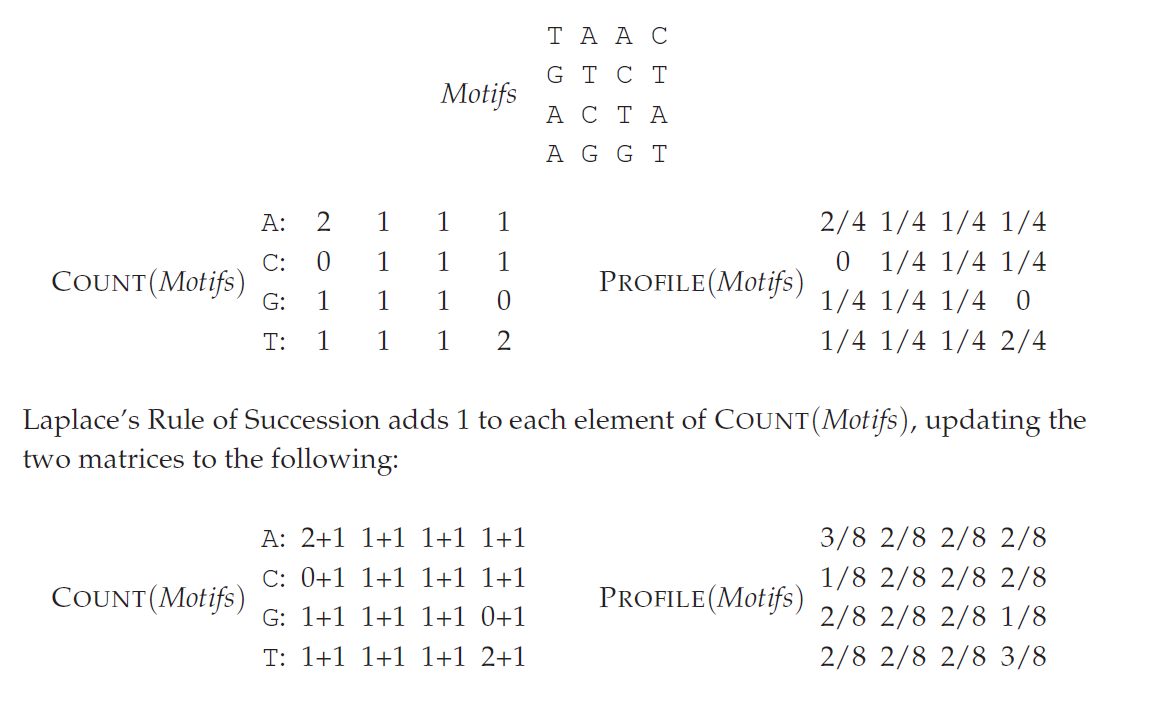

In [27]:
def generate_profile_with_pseudocounts(motifs):

  profile = {"A":[],"C":[],"G":[],"T":[]}
  t = len(motifs)
  k = min([len(string) for string in motifs])

  for i in range(k):
    nucleotides = []
    for string in motifs:
      nucleotides.append(string[i])
    for base in profile.keys():
      profile[base].append((nucleotides.count(base) + 1) / (t + 4))

  return profile

In [28]:
generate_profile(["TAAC","GTCT","ACTA","AGGT"])

{'A': [0.5, 0.25, 0.25, 0.25],
 'C': [0.0, 0.25, 0.25, 0.25],
 'G': [0.25, 0.25, 0.25, 0.0],
 'T': [0.25, 0.25, 0.25, 0.5]}

In [29]:
generate_profile_with_pseudocounts(["TAAC","GTCT","ACTA","AGGT"])

{'A': [0.375, 0.25, 0.25, 0.25],
 'C': [0.125, 0.25, 0.25, 0.25],
 'G': [0.25, 0.25, 0.25, 0.125],
 'T': [0.25, 0.25, 0.25, 0.375]}

In [30]:
def improved_greedy_motif_search(Dna,k):

  t = len(Dna)
  best_motifs = [string[:k] for string in Dna]
  best_score = find_score(best_motifs)

  for i in range(len(Dna[0])-k+1):
    motif_1 = Dna[0][i:i+k]
    motifs = [motif_1]

    for j in range(1,t):
      profile = generate_profile_with_pseudocounts(motifs)
      motifs.append(profile_most_probable(profile,Dna[j],k)[1])

    score = find_score(motifs)
    if score < best_score:
      best_motifs = motifs
      best_score = score

  return best_motifs, best_score

In [31]:
dna = [ "atgaccgggatactgatAgAAgAAAGGttGGGggcgtacacattagataaacgtatgaagtacgttagactcggcgccgccg".upper(),
        "acccctattttttgagcagatttagtgacctggaaaaaaaatttgagtacaaaacttttccgaatacAAtAAAAcGGcGGGa".upper(),
        "tgagtatccctgggatgacttAAAAtAAtGGaGtGGtgctctcccgatttttgaatatgtaggatcattcgccagggtccga".upper(),
        "gctgagaattggatgcAAAAAAAGGGattGtccacgcaatcgcgaaccaacgcggacccaaaggcaagaccgataaaggaga".upper(),
        "tcccttttgcggtaatgtgccgggaggctggttacgtagggaagccctaacggacttaatAtAAtAAAGGaaGGGcttatag".upper(),
        "gtcaatcatgttcttgtgaatggatttAAcAAtAAGGGctGGgaccgcttggcgcacccaaattcagtgtgggcgagcgcaa".upper(),
        "cggttttggcccttgttagaggcccccgtAtAAAcAAGGaGGGccaattatgagagagctaatctatcgcgtgcgtgttcat".upper(),
        "aacttgagttAAAAAAtAGGGaGccctggggcacatacaagaggagtcttccttatcagttaatgctgtatgacactatgta".upper(),
        "ttggcccattggctaaaagcccaacttgacaaatggaagatagaatccttgcatActAAAAAGGaGcGGaccgaaagggaag".upper(),
        "ctggtgagcaacgacagattcttacgtgcattagctcgcttccggggatctaatagcacgaagcttActAAAAAGGaGcGGa".upper()]

In [32]:
greedy_motif_search(dna,15)

(['GGGGCGTACACATTA',
  'ACCCCTATTTTTTGA',
  'TGAGTATCCCTGGGA',
  'GCTGAGAATTGGATG',
  'GGACTTAATATAATA',
  'GTCAATCATGTTCTT',
  'GGGCCAATTATGAGA',
  'GGGGCACATACAAGA',
  'TTGACAAATGGAAGA',
  'CTGGTGAGCAACGAC'],
 70)

In [33]:
improved_greedy_motif_search(dna,15)

(['TAGAAGAAAGGTTGG',
  'TGGAAAAAAAATTTG',
  'TAAAATAATGGAGTG',
  'CAAAAAAAGGGATTG',
  'TATAATAAAGGAAGG',
  'AACAATAAGGGCTGG',
  'TATAAACAAGGAGGG',
  'TAAAAAATAGGGAGC',
  'TACTAAAAAGGAGCG',
  'TACTAAAAAGGAGCG'],
 39)

Clearly, `improved_greedy_motif_search` is able to find a better scoring set of motifs than `greedy_motif_search`. While this is a commendable improvement from where we started, there is still scope for improvement.

# Randomized Motif Search

We will now turn to **randomized algorithms** that flip coins and roll dice in order to search for motifs. Randomized algorithms may be nonintuitive because they lack the control of traditional algorithms. Some randomized algorithms are **Las Vegas algorithms**, which deliver solutions that are guaranteed to be exact, despite the fact that they rely on making random decisions. Yet most randomized algorithms are **Monte Carlo algorithms**. These algorithms are not guaranteed to return exact solutions, but they do quickly find approximate solutions. Because of their speed, they can be run many times, allowing us to choose the best approximation from thousands of runs.

For a collection of strings $\text{Dna}$ and an arbitrary $4 \times k$ matrix $\text{Profile}$, we define $\text{Motifs(Profile, Dna)}$ as the collection of $k$-mers formed by the profile-most probable $k$-mers in each string of $\text{Dna}$. We then construct the profile matrix of $\text{Motifs}$ and use that to compute the profile-most probable $k$-mers in each string of $\text{Dna}$. Our hope is that the new collection of $\text{Motifs}$ has a better score than the previous one. We iterate as long as the score of the constructed motifs keeps improving. The initial profile matrix is generated by randomly selecting a $k$-mer from each string of $\text{Dna}$.

In [34]:
def randomized_motif_search(Dna,k):

  motifs = []
  for string in Dna:
    k_mers = []
    for i in range(len(string) - k + 1):
      k_mer = string[i:i+k]
      k_mers.append(k_mer)
    motifs.append(random.choice(k_mers))

  best_motifs = motifs.copy()
  best_score = find_score(best_motifs)

  while True:
    profile = generate_profile_with_pseudocounts(motifs)
    new_motifs = []
    for string in Dna:
      new_motifs.append(profile_most_probable(profile,string,k)[1])
    new_score = find_score(new_motifs)
    if new_score < best_score:
      best_score = new_score
      best_motifs = new_motifs.copy()
    else:
      return best_motifs, best_score

As a single run of `randomized_motif_search` may generate a rather poor set of motifs, bioinformaticians usually run this algorithm thousands of times. On each run, they begin from a new randomly selected set of $k$-mers, selecting the best set of $k$-mers found in all these runs.

In [35]:
dna = [ "atgaccgggatactgatAgAAgAAAGGttGGGggcgtacacattagataaacgtatgaagtacgttagactcggcgccgccg".upper(),
        "acccctattttttgagcagatttagtgacctggaaaaaaaatttgagtacaaaacttttccgaatacAAtAAAAcGGcGGGa".upper(),
        "tgagtatccctgggatgacttAAAAtAAtGGaGtGGtgctctcccgatttttgaatatgtaggatcattcgccagggtccga".upper(),
        "gctgagaattggatgcAAAAAAAGGGattGtccacgcaatcgcgaaccaacgcggacccaaaggcaagaccgataaaggaga".upper(),
        "tcccttttgcggtaatgtgccgggaggctggttacgtagggaagccctaacggacttaatAtAAtAAAGGaaGGGcttatag".upper(),
        "gtcaatcatgttcttgtgaatggatttAAcAAtAAGGGctGGgaccgcttggcgcacccaaattcagtgtgggcgagcgcaa".upper(),
        "cggttttggcccttgttagaggcccccgtAtAAAcAAGGaGGGccaattatgagagagctaatctatcgcgtgcgtgttcat".upper(),
        "aacttgagttAAAAAAtAGGGaGccctggggcacatacaagaggagtcttccttatcagttaatgctgtatgacactatgta".upper(),
        "ttggcccattggctaaaagcccaacttgacaaatggaagatagaatccttgcatActAAAAAGGaGcGGaccgaaagggaag".upper(),
        "ctggtgagcaacgacagattcttacgtgcattagctcgcttccggggatctaatagcacgaagcttActAAAAAGGaGcGGa".upper()]

In [36]:
k = 15

best_motifs = []
best_score = k*len(dna)
for i in range(2000):
  motifs, score = randomized_motif_search(dna,k)
  if score < best_score:
    best_score = score
    best_motifs = motifs.copy()
print(best_motifs)
print(best_score)

['GAAGAAAGGTTGGGG', 'AATAAAACGGCGGGA', 'AAAATAATGGAGTGG', 'ATGCAAAAAAAGGGA', 'ATAATAAAGGAAGGG', 'TTTAACAATAAGGGC', 'ATAAACAAGGAGGGC', 'GTTAAAAAATAGGGA', 'ACTAAAAAGGAGCGG', 'ACTAAAAAGGAGCGG']
40


Since the number of starting positions of $k$-mers is huge, the strategy of randomly selecting motifs is often not as successful. The chance that these randomly selected $k$-mers will be able to guide us to the optimal solution is relatively small.

# Gibbs Sampling

`randomized_motif_search` may change all strings in $\text{Motifs}$ in a single iteration. This strategy may prove reckless, since some correct motifs may potentially be discarded at the next iteration. **Gibbs sampling** is a more cautious iterative algorithm that discards a single $k$-mer from the current set of motifs at each iteration and decides to either keep it or replace it with a new one. This algorithm thus moves with more caution.

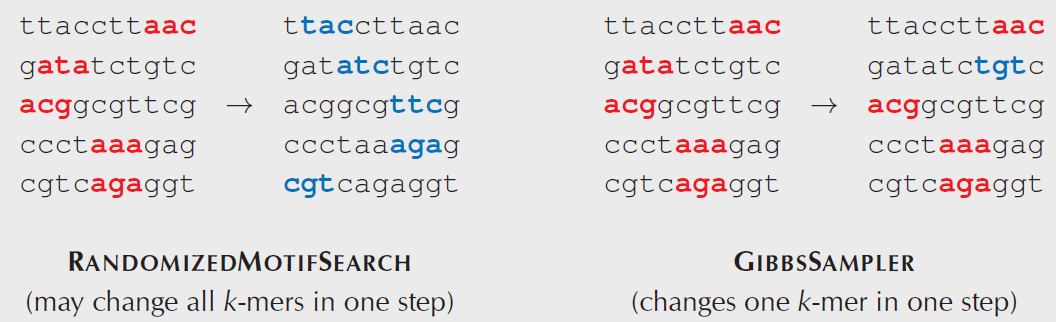

Gibbs sampling also starts with randomly chosen $k$-mers in each of $t$ DNA sequences, but it makes a random rather than a deterministic choice at each iteration. It randomly selects an integer $i$ between $1$ and $t$ and then randomly changes a single $k$-mer $\text{Motif}_i$.

To randomly change $\text{Motif}_i$, the algorithm computes the probabilities of all $k$-mers of $\text{Dna}_i$ being formed from the current profile matrix (excluding  $\text{Motif}_i$). These probabilities are used to constuct a biased die whose value on rolling decides which $k$-mer takes the place of $\text{Motif}_i$. This $k$-mer is called the **profile-randomly generated $k$-mer**.

In [37]:
def profile_randomly_generated(profile,string,k):

  k_mers = []
  probabilities = []

  for i in range(len(string)-k+1):
    k_mer = string[i:i+k]
    probability = 1
    for j in range(len(profile["A"])):
      nucleotide = k_mer[j]
      probability *= profile[nucleotide][j]
    k_mers.append(k_mer)
    probabilities.append(probability)

  new_probabilities = [p/sum(probabilities) for p in probabilities]

  chosen_k_mer = random.choices(population=k_mers, weights=new_probabilities)[0]

  return chosen_k_mer

In [38]:
def gibbs_sampler(Dna,k,N):

  t = len(Dna)

  motifs = []
  for string in Dna:
    k_mers = []
    for i in range(len(string) - k + 1):
      k_mer = string[i:i+k]
      k_mers.append(k_mer)
    motifs.append(random.choice(k_mers))

  best_motifs = motifs.copy()
  best_score = find_score(best_motifs)

  for j in range(N):
    i = random.randint(0,t-1)
    motifs_copy = motifs.copy()
    motifs_copy.remove(motifs[i])
    profile = generate_profile_with_pseudocounts(motifs_copy)
    motifs[i] = profile_randomly_generated(profile,Dna[i],k)

    score = find_score(motifs)
    if score < best_score:
      best_score = score
      best_motifs = motifs.copy()
    else:
      return best_motifs, best_score

In [39]:
dna = [ "atgaccgggatactgatAgAAgAAAGGttGGGggcgtacacattagataaacgtatgaagtacgttagactcggcgccgccg".upper(),
        "acccctattttttgagcagatttagtgacctggaaaaaaaatttgagtacaaaacttttccgaatacAAtAAAAcGGcGGGa".upper(),
        "tgagtatccctgggatgacttAAAAtAAtGGaGtGGtgctctcccgatttttgaatatgtaggatcattcgccagggtccga".upper(),
        "gctgagaattggatgcAAAAAAAGGGattGtccacgcaatcgcgaaccaacgcggacccaaaggcaagaccgataaaggaga".upper(),
        "tcccttttgcggtaatgtgccgggaggctggttacgtagggaagccctaacggacttaatAtAAtAAAGGaaGGGcttatag".upper(),
        "gtcaatcatgttcttgtgaatggatttAAcAAtAAGGGctGGgaccgcttggcgcacccaaattcagtgtgggcgagcgcaa".upper(),
        "cggttttggcccttgttagaggcccccgtAtAAAcAAGGaGGGccaattatgagagagctaatctatcgcgtgcgtgttcat".upper(),
        "aacttgagttAAAAAAtAGGGaGccctggggcacatacaagaggagtcttccttatcagttaatgctgtatgacactatgta".upper(),
        "ttggcccattggctaaaagcccaacttgacaaatggaagatagaatccttgcatActAAAAAGGaGcGGaccgaaagggaag".upper(),
        "ctggtgagcaacgacagattcttacgtgcattagctcgcttccggggatctaatagcacgaagcttActAAAAAGGaGcGGa".upper()]

In [40]:
k = 15

best_motifs = []
best_score = k*len(dna)
for i in range(2000):
  motifs, score = gibbs_sampler(dna,k,200)
  if score < best_score:
    best_score = score
    best_motifs = motifs.copy()
print(best_motifs)
print(best_score)

['GGGATACTGATAGAA', 'AATACAATAAAACGG', 'ACTTAAAATAATGGA', 'ATGCAAAAAAAGGGA', 'ATAATAAAGGAAGGG', 'ATTTAACAATAAGGG', 'TATAAACAAGGAGGG', 'GTTAAAAAATAGGGA', 'ACTAAAAAGGAGCGG', 'ACTAAAAAGGAGCGG']
49


Although `gibbs_sampler` performs well in many cases, it may converge to a suboptimal solution, particularly for difficult search problems with elusive motifs. A **local optimum** is a solution that is optimal within a small neighboring set of solutions, which is in contrast to a **global optimum**, or the optimal solution among all possible solutions. Since `gibbs_sampler` explores just a small subset of solutions, it may “get stuck” in a local optimum. For this reason, similarly to `randomized_motif_search`, it should be run many times with the hope that one of these runs will produce the best-scoring motifs.